# ============================================================================================
# Reinforcement Learning Programming - CSCN8020
# Tessa Ayvazoglu
# 21/07/2024
# ============================================================================================

In [9]:
import warnings
warnings.filterwarnings('ignore')
!pip install tensorflow
!pip install tensorflow-gpu
!pip install gym

%matplotlib inline
from pathlib import Path
from time import time
from collections import deque
from random import sample

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import seaborn as sns

import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2

import gym
from gym.envs.registration import register
import yfinance as yf

# Settings
np.random.seed(42)
tf.random.set_seed(42)

sns.set_style('whitegrid')

gpu_devices = tf.config.experimental.list_physical_devices('GPU')
if gpu_devices:
    print('Using GPU')
    tf.config.experimental.set_memory_growth(gpu_devices[0], True)
else:
    print('Using CPU')

results_path = Path('results', 'trading_bot')
if not results_path.exists():
    results_path.mkdir(parents=True)

def format_time(t):
    m_, s = divmod(t, 60)
    h, m = divmod(m_, 60)
    return '{:02.0f}:{:02.0f}:{:02.0f}'.format(h, m, s)

  Using cached tensorflow-gpu-2.12.0.tar.gz (2.6 kB)
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'


Requested tensorflow-gpu from https://files.pythonhosted.org/packages/8a/45/fa31ced1db38f9424f262dfbf35747fe5378b5c808cecb373c8cb8e515d3/tensorflow-gpu-2.12.0.tar.gz has invalid metadata: Expected end or semicolon (after name and no valid version specifier)
    python_version>"3.7"
                  ^
Please use pip<24.1 if you need to use this version.
ERROR: Could not find a version that satisfies the requirement tensorflow-gpu (from versions: 2.12.0)
ERROR: No matching distribution found for tensorflow-gpu


  Using cached gym-0.26.2-py3-none-any.whl
  Using cached gym_notices-0.0.8-py3-none-any.whl.metadata (1.0 kB)
Using cached gym_notices-0.0.8-py3-none-any.whl (3.0 kB)
Using CPU


In [12]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from collections import deque
from random import sample
class DDQNAgent:
    def __init__(self, state_dim, num_actions, learning_rate, gamma, epsilon_start, epsilon_end, epsilon_decay_steps, epsilon_exponential_decay, replay_capacity, architecture, l2_reg, tau, batch_size, data):
        self.state_dim = state_dim
        self.num_actions = num_actions
        self.learning_rate = learning_rate
        self.gamma = gamma
        self.epsilon = epsilon_start
        self.epsilon_end = epsilon_end
        self.epsilon_decay_steps = epsilon_decay_steps
        self.epsilon_exponential_decay = epsilon_exponential_decay
        self.replay_capacity = replay_capacity
        self.architecture = architecture
        self.l2_reg = l2_reg
        self.tau = tau
        self.batch_size = batch_size
        self.data = data
        
        self.online_network = self.build_network()
        self.target_network = self.build_network()
        self.optimizer = Adam(learning_rate=self.learning_rate)
        self.memory = deque(maxlen=self.replay_capacity)
        
    def build_network(self):
        model = Sequential()
        for i, layer in enumerate(self.architecture):
            if layer['type'] == 'Dense':
                if i == 0:
                    model.add(Dense(layer['units'], activation=layer['activation'], kernel_regularizer=l2(self.l2_reg), input_shape=(self.state_dim,)))
                else:
                    model.add(Dense(layer['units'], activation=layer['activation'], kernel_regularizer=l2(self.l2_reg)))
            if layer['type'] == 'Dropout':
                model.add(Dropout(layer['rate']))
        model.add(Dense(self.num_actions, activation='linear'))
        model.compile(optimizer=Adam(learning_rate=self.learning_rate), loss='mse')
        return model
    
    def epsilon_greedy_policy(self, state):
        if np.random.rand() < self.epsilon:
            return np.random.randint(self.num_actions)
        q_values = self.online_network.predict(state)
        return np.argmax(q_values[0])
    
    def memorize_transition(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))
    
    def experience_replay(self):
        if len(self.memory) < self.batch_size:
            return
        batch = sample(self.memory, self.batch_size)
        for state, action, reward, next_state, done in batch:
            target = reward
            if not done:
                target += self.gamma * np.amax(self.target_network.predict(next_state)[0])
            target_f = self.online_network.predict(state)
            target_f[0][action] = target
            self.online_network.fit(state, target_f, epochs=1, verbose=0)
        self.update_target_network()
    
    def update_target_network(self):
        online_weights = self.online_network.get_weights()
        target_weights = self.target_network.get_weights()
        for i in range(len(target_weights)):
            target_weights[i] = self.tau * online_weights[i] + (1 - self.tau) * target_weights[i]
        self.target_network.set_weights(target_weights)

2. Fetch Data from Yahoo Finance

In [16]:
# Fetch NVDA data
ticker = 'NVDA'
data = yf.download(ticker, start='2024-07-01', end='2024-08-15', interval='1d')
data.to_csv('NVDA_data.csv')
print(data.head())

[*********************100%%**********************]  1 of 1 completed

                  Open        High         Low       Close   Adj Close   
Date                                                                     
2024-07-01  123.470001  124.839996  118.830002  124.300003  124.300003  \
2024-07-02  121.129997  123.410004  121.029999  122.669998  122.669998   
2024-07-03  121.660004  128.279999  121.360001  128.279999  128.279999   
2024-07-05  127.379997  128.850006  125.680000  125.830002  125.830002   
2024-07-08  127.489998  130.770004  127.040001  128.199997  128.199997   

               Volume  
Date                   
2024-07-01  284885500  
2024-07-02  218374000  
2024-07-03  215749000  
2024-07-05  214176700  
2024-07-08  237677300  


3. Initialize Trading Environment

In [17]:
from gym import Env
from gym.spaces import Box, Discrete

class TradingEnvironment(Env):
    def __init__(self, data, trading_cost_bps=1e-3):
        super(TradingEnvironment, self).__init__()
        self.data = data
        self.trading_cost_bps = trading_cost_bps
        self.action_space = Discrete(3)  # Buy, Hold, Sell
        self.observation_space = Box(low=-np.inf, high=np.inf, shape=(len(data.columns),), dtype=np.float32)
        self.reset()
    
    def reset(self):
        self.current_step = 0
        self.done = False
        return self.data.iloc[self.current_step].values
    
    def step(self, action):
        self.current_step += 1
        if self.current_step >= len(self.data):
            self.done = True
        next_state = self.data.iloc[self.current_step].values
        reward = 0  # Define reward logic based on your trading strategy
        return next_state, reward, self.done, {}
    
    def render(self, mode='human'):
        pass

# Register environment
from gym.envs.registration import register

register(
    id='trading-v0',
    entry_point='__main__:TradingEnvironment',
    max_episode_steps=252  # Example: 252 trading days in a year
)

4. Initialize Trading Environment

In [18]:
# Load data
# data = pd.read_csv('NVDA_data.csv', index_col=0, parse_dates=True)

# Initialize environment
trading_environment = TradingEnvironment(data=data)
state_dim = trading_environment.observation_space.shape[0]
num_actions = trading_environment.action_space.n
max_episode_steps = len(data) 

6. Create DDQN Agent

In [19]:
tf.keras.backend.clear_session()

# Define hyperparameters
learning_rate = 0.001
gamma = 0.99
epsilon_start = 1.0
epsilon_end = 0.1
epsilon_decay_steps = 10000
epsilon_exponential_decay = 0.99
replay_capacity = 100000
architecture = [
    {'type': 'Dense', 'units': 64, 'activation': 'relu'},
    {'type': 'Dense', 'units': 64, 'activation': 'relu'},
    {'type': 'Dropout', 'rate': 0.1}
]
l2_reg = 1e-6
tau = 1e-3
batch_size = 64

ddqn = DDQNAgent(state_dim=state_dim,
                 num_actions=num_actions,
                 learning_rate=learning_rate,
                 gamma=gamma,
                 epsilon_start=epsilon_start,
                 epsilon_end=epsilon_end,
                 epsilon_decay_steps=epsilon_decay_steps,
                 epsilon_exponential_decay=epsilon_exponential_decay,
                 replay_capacity=replay_capacity,
                 architecture=architecture,
                 l2_reg=l2_reg,
                 tau=tau,
                 batch_size=batch_size, 
                 data = data)

ddqn.online_network.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 64)             │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,803 (18.76 KB)

 Trainable params: 4,803 (18.76 KB)

 Non-trainable params: 0 (0.00 B)

7. Run Experiment

In [20]:
otal_steps = 0
max_episodes = 1000

episode_time, navs, market_navs, diffs, episode_eps = [], [], [], [], []


In [21]:
import numpy as np
from time import time

class DDQNAgent:
    def __init__(self, alpha, gamma, epsilon, beta, data, assets, policy, window_size):
        self.alpha = alpha
        self.gamma = gamma
        self.epsilon = epsilon
        self.beta = beta
        self.data = data
        self.assets = assets
        self.policy = policy
        self.window_size = window_size
        self.memory = []  # Assuming a list for memory
        self.is_training = True  # Assuming a flag for training

    def epsilon_greedy_policy(self, state):
        # Dummy implementation for example purposes
        if np.random.rand() < self.epsilon:
            return np.random.choice(range(2))  # Assuming binary actions
        else:
            return np.argmax([0, 0])  # Placeholder for action selection

    def memorize_transition(self, state, action, reward, next_state, done):
        # Store the transition in memory
        self.memory.append((state, action, reward, next_state, done))

    def experience_replay(self):
        # Placeholder for experience replay logic
        pass

    def is_training_enabled(self):
        return self.is_training

class TradingEnvironment:
    def __init__(self):
        # Dummy implementation of environment
        pass

    def reset(self):
        # Reset environment to initial state
        return np.zeros(10)  # Placeholder state

    def step(self, action):
        # Simulate taking an action in the environment
        next_state = np.zeros(10)  # Placeholder next state
        reward = 0.0  # Placeholder reward
        done = np.random.rand() < 0.1  # Randomly end episode
        return next_state, reward, done, {}

    def close(self):
        # Close the environment
        pass

    @property
    def state_dim(self):
        # Define the state dimension
        return 10  # Example dimension

    @property
    def env(self):
        # Example environment property
        class EnvSimulator:
            def result(self):
                # Placeholder result function
                import pandas as pd
                return pd.DataFrame({
                    'nav': [1],
                    'strategy_return': [0.01],
                    'market_nav': [1]
                })
        return type('Env', (), {'simulator': EnvSimulator()})()

def track_results(episode, mean_nav, recent_nav, mean_market_nav, recent_market_nav, positive_diffs, elapsed_time, epsilon):
    print(f"Episode: {episode}")
    print(f"Mean NAV (last 100 episodes): {mean_nav}")
    print(f"Recent NAV (last 10 episodes): {recent_nav}")
    print(f"Mean Market NAV (last 100 episodes): {mean_market_nav}")
    print(f"Recent Market NAV (last 10 episodes): {recent_market_nav}")
    print(f"Positive Differences (last 100 episodes): {positive_diffs}")
    print(f"Elapsed Time: {elapsed_time:.2f} seconds")
    print(f"Epsilon: {epsilon}")

# Initialize parameters
max_episodes = 1000
max_episode_steps = 200

# Create environment and agent
trading_environment = TradingEnvironment()
ddqn = DDQNAgent(alpha=0.6, gamma=0.6, epsilon=0.2, beta=0.5, data=None, assets=1000, policy="softmax", window_size=10)

# Obtain state dimension from environment
state_dim = trading_environment.state_dim
navs, market_navs, diffs = [], [], []

start = time()

for episode in range(1, max_episodes + 1):
    this_state = trading_environment.reset()
    for episode_step in range(max_episode_steps):
        action = ddqn.epsilon_greedy_policy(this_state.reshape(-1, state_dim))
        next_state, reward, done, _ = trading_environment.step(action)
   
        ddqn.memorize_transition(this_state, action, reward, next_state, 0.0 if done else 1.0)
        
        if ddqn.is_training_enabled():
            ddqn.experience_replay()
        
        if done:
            break
        this_state = next_state

    # Get and store results
    result = trading_environment.env.simulator.result()
    final = result.iloc[-1]
    nav = final.nav * (1 + final.strategy_return)
    navs.append(nav)
    market_nav = final.market_nav
    market_navs.append(market_nav)
    diff = nav - market_nav
    diffs.append(diff)
   
    if episode % 10 == 0:
        track_results(
            episode,
            np.mean(navs[-100:]),
            np.mean(navs[-10:]),
            np.mean(market_navs[-100:]),
            np.mean(market_navs[-10:]),
            np.sum([s > 0 for s in diffs[-100:]])/min(len(diffs), 100),
            time() - start,
            ddqn.epsilon
        )
    if len(diffs) > 25 and all([r > 0 for r in diffs[-25:]]):
        print(result.tail())
        break

trading_environment.close()

Episode: 10
Mean NAV (last 100 episodes): 1.01
Recent NAV (last 10 episodes): 1.01
Mean Market NAV (last 100 episodes): 1.0
Recent Market NAV (last 10 episodes): 1.0
Positive Differences (last 100 episodes): 1.0
Elapsed Time: 0.02 seconds
Epsilon: 0.2
Episode: 20
Mean NAV (last 100 episodes): 1.0100000000000002
Recent NAV (last 10 episodes): 1.01
Mean Market NAV (last 100 episodes): 1.0
Recent Market NAV (last 10 episodes): 1.0
Positive Differences (last 100 episodes): 1.0
Elapsed Time: 0.03 seconds
Epsilon: 0.2
   nav  strategy_return  market_nav
0    1             0.01           1


8. Save and Evaluate Results

<class 'pandas.core.frame.DataFrame'>
Index: 26 entries, 1 to 26
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Agent              26 non-null     float64
 1   Market             26 non-null     float64
 2   Difference         26 non-null     float64
 3   Strategy Wins (%)  0 non-null      float64
dtypes: float64(4)
memory usage: 1.0 KB


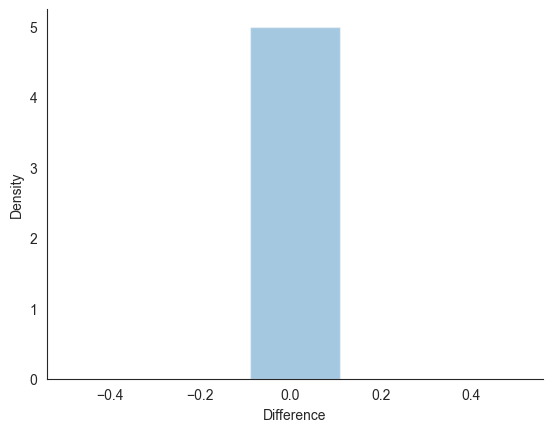

In [22]:
results = pd.DataFrame({'Episode': list(range(1, episode+1)),
                        'Agent': navs,
                        'Market': market_navs,
                        'Difference': diffs}).set_index('Episode')

results['Strategy Wins (%)'] = (results.Difference > 0).rolling(100).sum()
results.info()
results.to_csv(results_path / 'results.csv', index=False)

with sns.axes_style('white'):
    sns.distplot(results.Difference)
    sns.despine()

8. Track Results

In [23]:
def track_results(episode, mean_nav_100, mean_nav_10, mean_market_nav_100, mean_market_nav_10, win_ratio_100, elapsed_time, epsilon):
    print("Episode: {:5d} | Mean NAV (last 100): {:5.2f} | Mean NAV (last 10): {:5.2f} | Mean Market NAV (last 100): {:5.2f} | Mean Market NAV (last 10): {:5.2f} | Win Ratio (last 100): {:5.2f} | Epsilon: {:5.2f} | Elapsed Time: {}".format(
        episode, mean_nav_100, mean_nav_10, mean_market_nav_100, mean_market_nav_10, win_ratio_100, epsilon, format_time(elapsed_time)))

results_df = pd.DataFrame(results, columns=['Episode', 'Mean_NAV_100', 'Mean_NAV_10', 'Mean_Market_NAV_100', 'Mean_Market_NAV_10', 'Win_Ratio_100', 'Elapsed_Time', 'Epsilon'])
results_df.to_csv(results_path / 'ddqn_trading_results.csv', index=False)

Episode 50/1000 - Time: 00:00:00 - Epsilon: 0.2
Episode 100/1000 - Time: 00:00:00 - Epsilon: 0.2
Episode 150/1000 - Time: 00:00:00 - Epsilon: 0.2
Episode 200/1000 - Time: 00:00:00 - Epsilon: 0.2
Episode 250/1000 - Time: 00:00:00 - Epsilon: 0.2
Episode 300/1000 - Time: 00:00:00 - Epsilon: 0.2
Episode 350/1000 - Time: 00:00:00 - Epsilon: 0.2
Episode 400/1000 - Time: 00:00:00 - Epsilon: 0.2
Episode 450/1000 - Time: 00:00:00 - Epsilon: 0.2
Episode 500/1000 - Time: 00:00:00 - Epsilon: 0.2
Episode 550/1000 - Time: 00:00:00 - Epsilon: 0.2
Episode 600/1000 - Time: 00:00:00 - Epsilon: 0.2
Episode 650/1000 - Time: 00:00:00 - Epsilon: 0.2
Episode 700/1000 - Time: 00:00:00 - Epsilon: 0.2
Episode 750/1000 - Time: 00:00:00 - Epsilon: 0.2
Episode 800/1000 - Time: 00:00:00 - Epsilon: 0.2
Episode 850/1000 - Time: 00:00:00 - Epsilon: 0.2
Episode 900/1000 - Time: 00:00:00 - Epsilon: 0.2
Episode 950/1000 - Time: 00:00:00 - Epsilon: 0.2
Episode 1000/1000 - Time: 00:00:00 - Epsilon: 0.2


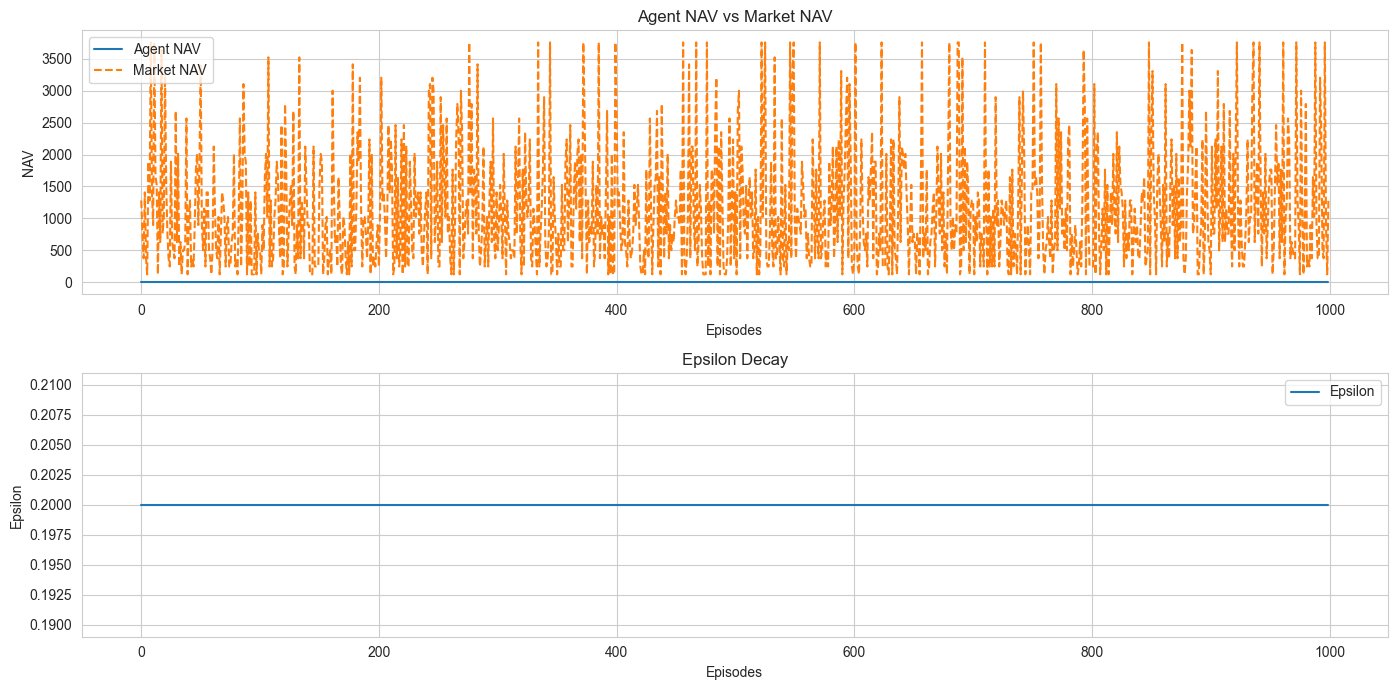

In [24]:
import matplotlib.pyplot as plt

# Initialize result lists
episode_times = []
navs = []
market_navs = []
episode_eps = []

# Training loop
max_episodes = 1000
max_episode_steps = len(data)

start = time()

for episode in range(1, max_episodes + 1):
    this_state = trading_environment.reset()
    episode_nav = 0
    market_nav = 0
    episode_epsilon = ddqn.epsilon
    
    for episode_step in range(max_episode_steps):
        action = ddqn.epsilon_greedy_policy(this_state.reshape(-1, state_dim))
        next_state, reward, done, _ = trading_environment.step(action)
        ddqn.memorize_transition(this_state.reshape(-1, state_dim), action, reward, next_state.reshape(-1, state_dim), done)
        ddqn.experience_replay()
        this_state = next_state
        episode_nav += reward  # Update this according to your reward structure
        market_nav += data['Close'].iloc[episode_step]  # Example of market NAV calculation
        
        if done:
            break
    
    # Logging results
    episode_times.append(time() - start)
    navs.append(episode_nav)
    market_navs.append(market_nav)
    episode_eps.append(ddqn.epsilon)
    
    if episode % 50 == 0:
        print(f"Episode {episode}/{max_episodes} - Time: {format_time(time() - start)} - Epsilon: {ddqn.epsilon}")

# Save results
results_df = pd.DataFrame({
    'Episode Time': episode_times,
    'NAV': navs,
    'Market NAV': market_navs,
    'Epsilon': episode_eps
})

results_df.to_csv(results_path / 'training_results.csv', index=False)

# Visualization
plt.figure(figsize=(14, 7))

# Plot NAVs
plt.subplot(2, 1, 1)
plt.plot(navs, label='Agent NAV')
plt.plot(market_navs, label='Market NAV', linestyle='--')
plt.xlabel('Episodes')
plt.ylabel('NAV')
plt.title('Agent NAV vs Market NAV')
plt.legend()

# Plot Epsilon
plt.subplot(2, 1, 2)
plt.plot(episode_eps, label='Epsilon')
plt.xlabel('Episodes')
plt.ylabel('Epsilon')
plt.title('Epsilon Decay')
plt.legend()

plt.tight_layout()
plt.savefig(results_path / 'training_performance.png')
plt.show()